## Configuration for using Google Colab and copying dataset

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/nul

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
datalab  drive


In [149]:
!cp ./drive/data/carnd1-vehicle-detection/*.tar.gz ./
!cp ./drive/data/carnd1-vehicle-detection/*.mp4 ./
!tar -xvzf non-vehicles_smallset.tar.gz 2>null
!tar -xvzf vehicles_smallset.tar.gz 2>null
!tar -xvzf test_images.tar.gz 2>null
!mkdir smallset
!mv non-vehicles_smallset smallset
!mv vehicles_smallset smallset
!cp ./drive/data/carnd1-vehicle-detection/bbox-example-image.jpg ./
!cp ./drive/data/carnd1-vehicle-detection/lesson_functions.py ./
!pip install moviepy
!ls


    100% |████████████████████████████████| 399kB 2.4MB/s 
    100% |████████████████████████████████| 3.3MB 383kB/s 
    100% |████████████████████████████████| 51kB 9.7MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/52/38/7a/cf4fde74a205aadaab182a14f2b28651297beaaba00156b42f
Successfully built moviepy
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
bbox-example-image.jpg	non-vehicles_smallset.tar.gz  test_images
datalab			project_video.mp4	      test_images.tar.gz
drive			__pycache__		      test_video.mp4
lesson_functions.py	smallset		      vehicles_smallset.tar.gz


## Feature extraction and listing image paths
Features extraction is processed with functions from lession_functions.py. The features consists of HOG, binned color, and color histogram.

In [0]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from lesson_functions import *
from IPython.display import HTML
%matplotlib inline

# Read in cars and notcars
images = glob.glob('./smallset/**/*.jpeg', recursive=True)
print(images[:10])
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

Here is an example using HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2,2) 

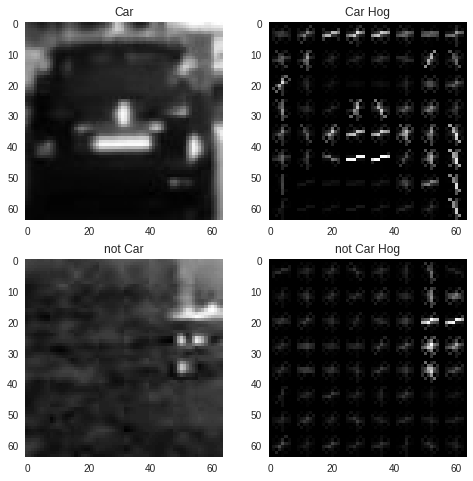

In [82]:
car_file = cars[np.random.randint(0, sample_size)]
not_car_file = notcars[np.random.randint(0, sample_size)]

plt.figure(figsize=(8, 8))
image = mpimg.imread(car_file)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
car_features, car_hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
plt.subplot(221)
plt.imshow(gray, cmap='gray')
plt.title('Car')
plt.grid(False)
plt.subplot(222)
plt.title('Car Hog')
plt.imshow(car_hog_image, cmap='gray')
plt.grid(False)

image = mpimg.imread(not_car_file)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
not_car_features, not_car_hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
plt.subplot(223)
plt.imshow(gray, cmap='gray')
plt.title('not Car')
plt.grid(False)
plt.subplot(224)
plt.imshow(not_car_hog_image, cmap='gray')
plt.title('not Car Hog')
plt.grid(False)

## Finding best parameters with SVM classifier

In [83]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
  
### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('|{0}|{1}|{2}|{3}|{4}|{5}|'.format(color_space,orient , pix_per_cell,cell_per_block , hog_channel,round(svc.score(X_test, y_test), 4)))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
0.2 Seconds to train SVC...
|LUV|9|8|2|ALL|1.0|


Test the svc model on test image

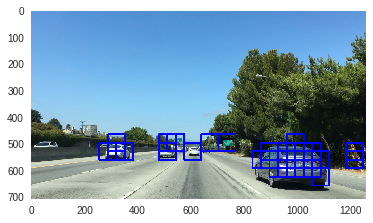

In [84]:
image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)
plt.grid(False)

## Search best classifier

Using the Scikit-learn linear SVM classifier and GridSearchCV

In [0]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
svr = SVC()
grid_search = GridSearchCV(svr, parameters)
grid_search.fit(X, y)

print('best SVM parameters:', grid_search.best_params_)
print('best score:', grid_search.best_score_)

Using the Scikit-learn RBF kernel SVM classifier and GridSearchCV

In [0]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1, 1]}
svr = SVC(kernel='rbf')
grid_search = GridSearchCV(svr, parameters)
grid_search.fit(X, y)

print('best SVM parameters:', grid_search.best_params_)
print('best score:', grid_search.best_score_)

Using the Scikit-learn LinearSVC classifier and GridSearchCV

In [38]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
svr = svm.LinearSVC()
grid_search = GridSearchCV(svr, parameters)
grid_search.fit(X, y)

print('best SVM parameters:', grid_search.best_params_)
print('best score:', grid_search.best_score_)

best SVM parameters: {'C': 0.1}
best score: 0.936


## Slinding window

The function find_cars come from Udacity's lecture and is changed to return retangles of the areas of the detected cars.
It will be used to calculate heat map of each area of car. And, It will get the color space parameter for converting an image.

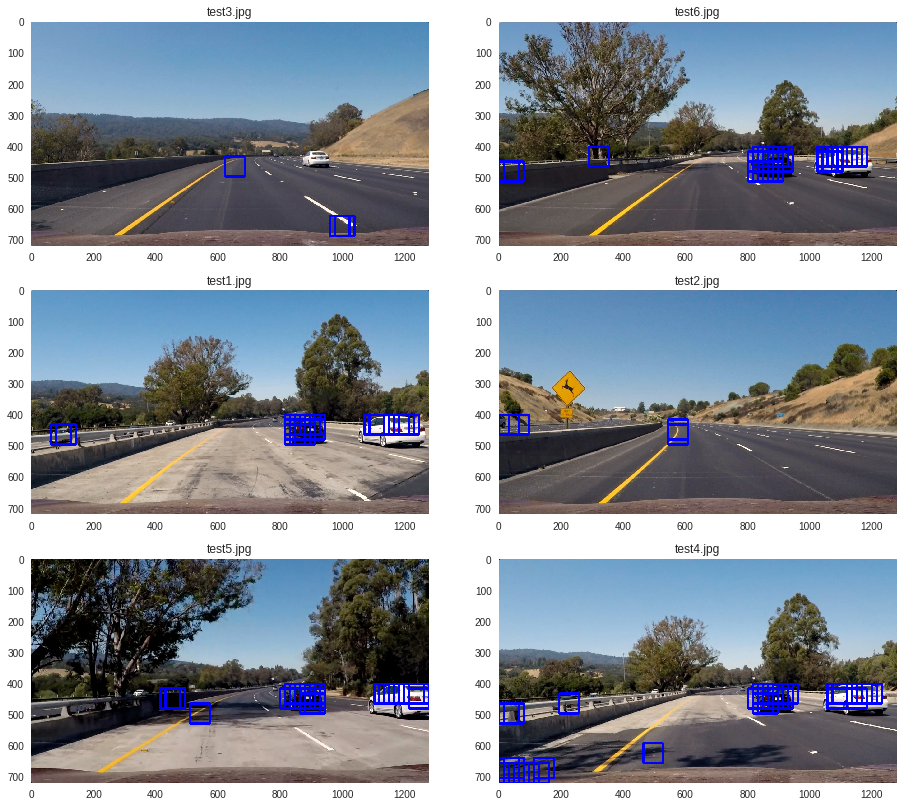

In [139]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    rectangles = [] # used to keep the rectangles of the detected cars.
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)  
      
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
  
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
  
# Read in and test on test images
ystart = 400
ystop = None
scale = 1
plt.figure(figsize=(16,14))
plt.subplots_adjust(hspace=0.2, wspace=0.1)
idx = 1
img1_box_list = None
for filename in glob.glob('./test_images/*.jpg'):
    test_image = mpimg.imread(filename)
    # test_image = mpimg.imread('./bbox-example-image.jpg')
    rectangles = find_cars(test_image, ystart=ystart, ystop=ystop, scale=scale, svc=svc, 
                         cspace=color_space, X_scaler=X_scaler, orient=orient, 
                         pix_per_cell=pix_per_cell, spatial_size=spatial_size, 
                         cell_per_block=cell_per_block, hist_bins=hist_bins)
    if filename.split('/')[-1] == 'test1.jpg':
      img1_box_list = rectangles
    output = draw_boxes(test_image, rectangles)
    ax = plt.subplot(3,2,idx)
    plt.imshow(output)
    plt.title(filename.split('/')[-1])
    plt.grid(False)
    idx += 1

## Heatmap

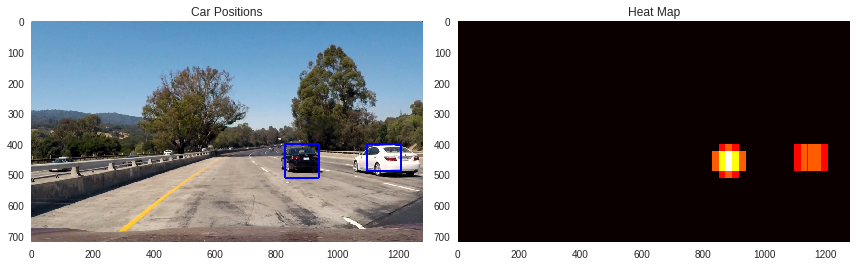

In [105]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,img1_box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.grid(False)

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.grid(False)
fig.tight_layout()

## Video Implementation
Implement frame processing pipeline and run the pipeline on all test images

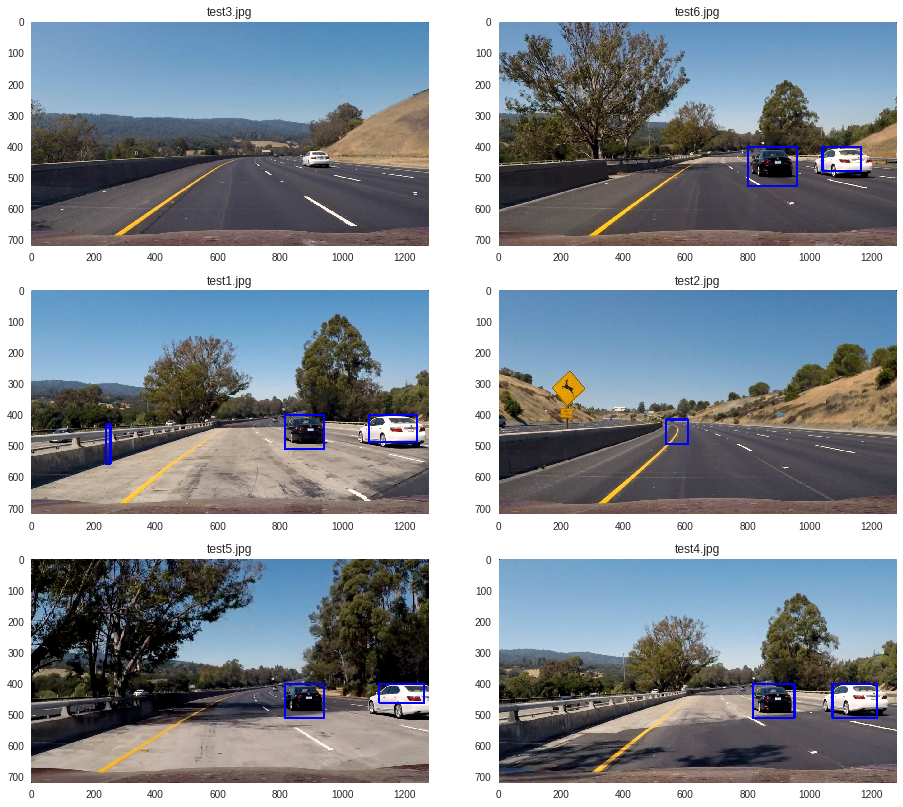

In [145]:
def process_frame(img):
  rectangles = []
  
  cspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
  orient = 9  # HOG orientations
  pix_per_cell = 8 # HOG pixels per cell
  cell_per_block = 2 # HOG cells per block
  spatial_size = (16, 16) # Spatial binning dimensions
  hist_bins = 32    # Number of histogram bins
  
  rectangles += find_cars(img, 400, 660, 0.7, cspace, svc, X_scaler, orient, 
                         pix_per_cell, cell_per_block, spatial_size, hist_bins)
  rectangles += find_cars(img, 400, 660, 1.0, cspace, svc, X_scaler, orient, 
                         pix_per_cell, cell_per_block, spatial_size, hist_bins)
  rectangles += find_cars(img, 400, 660, 1.4, cspace, svc, X_scaler, orient, 
                         pix_per_cell, cell_per_block, spatial_size, hist_bins)
  rectangles += find_cars(img, 400, 660, 2.0, cspace, svc, X_scaler, orient, 
                         pix_per_cell, cell_per_block, spatial_size, hist_bins)
  rectangles += find_cars(img, 400, 660, 2.5, cspace, svc, X_scaler, orient, 
                         pix_per_cell, cell_per_block, spatial_size, hist_bins)
  
  heat = np.zeros_like(img[:,:,0]).astype(np.float)
  heat = add_heat(heat,rectangles)
  heat = apply_threshold(heat,5)
  heatmap = np.clip(heat, 0, 255)
  labels = label(heatmap)
  draw_img = draw_labeled_bboxes(np.copy(img), labels)
  
  return draw_img
  
plt.figure(figsize=(16,14))
plt.subplots_adjust(hspace=0.2, wspace=0.1)
idx = 1
for filename in glob.glob('./test_images/*.jpg'):
    test_image = mpimg.imread(filename)
    output = process_frame(test_image)
    ax = plt.subplot(3,2,idx)
    plt.imshow(output)
    plt.title(filename.split('/')[-1])
    plt.grid(False)
    idx += 1

Video processing with my pipeline

In [150]:
from moviepy.editor import VideoFileClip
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)851968/45929032 bytes (1.9%)2293760/45929032 bytes (5.0%)4997120/45929032 bytes (10.9%)8167424/45929032 bytes (17.8%)11624448/45929032 bytes (25.3%)14991360/45929032 bytes (32.6%)18317312/45929032 bytes (39.9%)21774336/45929032 bytes (47.4%)25272320/45929032 bytes (55.0%)28631040/45929032 bytes (62.3%)31899648/45929032 bytes (69.5%)35414016/45929032 bytes (77.1%)38780

 97%|█████████▋| 38/39 [03:22<00:05,  5.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 3min 21s, sys: 374 ms, total: 3min 22s
Wall time: 3min 25s


In [158]:
!ls -al
!cp test_video_out.mp4 ./drive/data/carnd1-vehicle-detection/

total 30384
drwxr-xr-x 1 root root      4096 Apr 20 08:28 .
drwxr-xr-x 1 root root      4096 Apr 20 01:01 ..
-rw-r--r-- 1 root root    212517 Apr 20 01:04 bbox-example-image.jpg
drwx------ 4 root root      4096 Apr 20 01:02 .cache
drwxr-xr-x 3 root root      4096 Apr 20 01:02 .config
drwxr-xr-x 1 root root      4096 Apr 20 01:03 datalab
drwxr-xr-x 2 root root      4096 Apr 20 01:04 drive
drwxr-xr-x 4 root root      4096 Apr 20 01:02 .forever
drwx------ 3 root root      4096 Apr 20 01:03 .gdfuse
drwxr-xr-x 3 root root      4096 Apr 20 08:27 .imageio
drwxr-xr-x 5 root root      4096 Apr 20 01:02 .ipython
-rw-r--r-- 1 root root      7168 Apr 20 01:27 lesson_functions.py
drwx------ 3 root root      4096 Apr 20 01:02 .local
-rwxr-xr-x 1  501 staff      212 Apr 17 12:33 ._non-vehicles_smallset
-rw-r--r-- 1 root root    940659 Apr 20 01:04 non-vehicles_smallset.tar.gz
-rw-r--r-- 1 root root  25268015 Apr 20 08:25 project_video.mp4
drwxr-xr-x 2 root root      4096 Apr 20 01:28 __pycache__
-rw-

In [0]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [0]:
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 3/1261 [00:16<1:52:10,  5.35s/it]